In [1]:
import pandas as pd 
import janitor

def get_data():
    URL_CSV="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    df = pd.read_csv(URL_CSV)
    df['Country/Region'] = df['Country/Region'].replace({'US':'United States of America'})
    return df
df = get_data()
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,43240,43403,43628,43851,44228,44443,44503,44706,44988,45280
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,27830,28432,29126,29837,30623,31459,32196,32761,33556,34300
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,67679,68589,69591,70629,71652,72755,73774,74862,75867,77000
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,5872,5914,5951,6018,6066,6142,6207,6256,6304,6351
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,13451,13615,13818,13922,14134,14267,14413,14493,14634,14742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,63031,63867,64935,66186,67296,68768,70254,71644,73196,75007
267,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
268,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2072,2078,2081,2083,2086,2090,2093,2099,2107,2114
269,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,17123,17187,17243,17280,17350,17373,17394,17424,17454,17466


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2,2020-01-24,-1.513473e+04,0.000000e+00,6.660197e+05,-1.513473e+04,-1.513473e+04,19081.432894,19081.432894,19081.432894,19081.432894,19081.432894,19081.432894,0.0,0.0,0.0,3.946698e+03
3,2020-01-25,-1.197621e+04,0.000000e+00,6.871946e+05,-1.197621e+04,-1.197621e+04,21271.837859,21271.837859,21271.837859,21271.837859,21271.837859,21271.837859,0.0,0.0,0.0,9.295627e+03
9,2020-01-31,6.974932e+03,0.000000e+00,6.875132e+05,6.974932e+03,6.974932e+03,19081.432894,19081.432894,19081.432894,19081.432894,19081.432894,19081.432894,0.0,0.0,0.0,2.605636e+04
10,2020-02-01,1.013346e+04,0.000000e+00,6.781416e+05,1.013346e+04,1.013346e+04,21271.837859,21271.837859,21271.837859,21271.837859,21271.837859,21271.837859,0.0,0.0,0.0,3.140529e+04
11,2020-02-02,1.329197e+04,0.000000e+00,6.870568e+05,1.329197e+04,1.329197e+04,-2000.276826,-2000.276826,-2000.276826,-2000.276826,-2000.276826,-2000.276826,0.0,0.0,0.0,1.129170e+04
12,2020-02-03,1.645049e+04,0.000000e+00,6.815901e+05,1.645049e+04,1.645049e+04,-6981.723779,-6981.723779,-6981.723779,-6981.723779,-6981.723779,-6981.723779,0.0,0.0,0.0,9.468769e+03
13,2020-02-04,1.960901e+04,0.000000e+00,6.453231e+05,1.960901e+04,1.960901e+04,192.705432,192.705432,192.705432,192.705432,192.705432,192.705432,0.0,0.0,0.0,1.980172e+04
15,2020-02-06,2.592605e+04,0.000000e+00,7.007776e+05,2.592605e+04,2.592605e+04,-5205.278733,-5205.278733,-5205.278733,-5205.278733,-5205.278733,-5205.278733,0.0,0.0,0.0,2.072077e+04
16,2020-02-07,2.908457e+04,0.000000e+00,7.036126e+05,2.908457e+04,2.908457e+04,19081.432894,19081.432894,19081.432894,19081.432894,19081.432894,19081.432894,0.0,0.0,0.0,4.816600e+04
17,2020-02-08,3.224308e+04,0.000000e+00,6.775784e+05,3.224308e+04,3.224308e+04,21271.837859,21271.837859,21271.837859,21271.837859,21271.837859,21271.837859,0.0,0.0,0.0,5.351492e+04


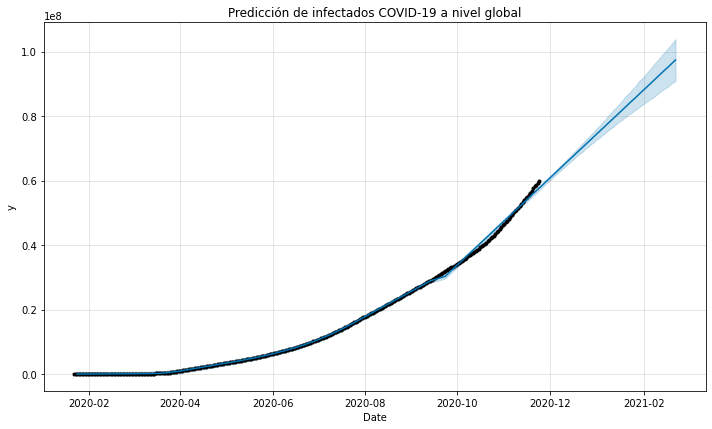

In [2]:
import janitor
import pandas as pd
import pandas_flavor as pf
import fbprophet
from matplotlib import pyplot as plt    
from IPython.display import display, HTML



LISTA_COLUMNAS_A_BORRAR = ['Province/State', 'Country/Region', 'Lat', 'Long']



df = get_data()
df = df.remove_columns(LISTA_COLUMNAS_A_BORRAR)
df
df = pd.DataFrame( df.sum())
df.columns=['y']
df.index = pd.to_datetime(df.index)  
df['ds'] = df.index
df = df.reset_index()


df = df.remove_columns(['index'])


df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
df_prophet.fit(df)

df_forecast = df_prophet.make_future_dataframe(periods=90, freq='D')
# Make predictions
df_forecast = df_prophet.predict(df_forecast)
df_forecast

df_forecast = df_forecast[df_forecast["yhat"] >= 0]
df_forecast.loc[df_forecast.yhat_lower < 0, 'yhat_lower'] = 0


df_prophet.plot(df_forecast, xlabel = 'Date' )
plt.title('Predicción de infectados COVID-19 a nivel global'   )

display(HTML(pd.DataFrame(df_forecast).to_html()))


In [3]:
df = get_data()
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,43240,43403,43628,43851,44228,44443,44503,44706,44988,45280
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,27830,28432,29126,29837,30623,31459,32196,32761,33556,34300
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,67679,68589,69591,70629,71652,72755,73774,74862,75867,77000
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,5872,5914,5951,6018,6066,6142,6207,6256,6304,6351
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,13451,13615,13818,13922,14134,14267,14413,14493,14634,14742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,63031,63867,64935,66186,67296,68768,70254,71644,73196,75007
267,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
268,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2072,2078,2081,2083,2086,2090,2093,2099,2107,2114
269,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,17123,17187,17243,17280,17350,17373,17394,17424,17454,17466


In [4]:

import janitor
import datetime
import numpy as np

def pipeline_populations():
    """ Cogemos un dataframe de poblaciones"""

    URL="https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv"
    THIS_YEAR = datetime.datetime.now().year

    return (
        pd.read_csv(URL)
        .filter_on( f""" Time  ==  {THIS_YEAR} & Variant == "Medium" """ ) 
        .select_columns(['Location','PopTotal'])
        .join_apply(lambda x: x['PopTotal'] * 1000 , new_column_name="PopMillions" )
        .remove_columns(['PopTotal'])
        .rename_column('PopMillions' , 'PopTotal')
        .transform_column('PopTotal',np.int64)
        .rename_column('Location' , 'Country/Region')
    )


populations = pipeline_populations()
populations

,Country/Region,PopTotal
70,Afghanistan,38928341
954,Africa,1340598113
1838,African Group,1338826591
1989,African Union,1339423920
2140,African Union: Central Africa,158619638
...,...,...
277315,World,7794798728
278199,World Bank Regional Groups (developing only),6528762227
278350,Yemen,29825967
279234,Zambia,18383956


In [5]:
df = get_data()
df_country = pd.DataFrame()
df_country['Country/Region'] = df['Country/Region']
df_country['infected last_day'] = df.iloc[:,-1] - df.iloc[:,-2]
df_country.set_index('Country/Region')
df_country

,Country/Region,infected last_day
0,Afghanistan,292
1,Albania,744
2,Algeria,1133
3,Andorra,47
4,Angola,108
...,...,...
266,West Bank and Gaza,1811
267,Western Sahara,0
268,Yemen,7
269,Zambia,12


In [6]:
df_country_enrich = pd.merge(df_country, populations, on="Country/Region")
df_country_enrich['Infected/Million'] =  1000000 * df_country_enrich['infected last_day'] / df_country_enrich['PopTotal'] 
df_country = df_country_enrich

In [7]:
df_country.sort_values(by='Infected/Million', ascending=False).head(10)

,Country/Region,infected last_day,PopTotal,Infected/Million
220,Sweden,17265,10099270,1709.529501
171,Montenegro,570,628062,907.553713
194,Poland,32733,37846605,864.886031
124,Georgia,3128,3989175,784.122030
206,Serbia,6842,8737370,783.073167
30,Bulgaria,4382,6948445,630.644698
211,Slovenia,1302,2078932,626.283111
3,Andorra,47,77265,608.296124
158,Luxembourg,373,625976,595.869490
91,Croatia,2323,4105268,565.858307


In [8]:
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates


def pintar_grafico(df, array_naciones_pintar ,title):
    df = df.T
    df = df.iloc[1:]
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header
    df = df.iloc[2:]
    df.index = pd.to_datetime(df.index)
    df = df[array_naciones_pintar]
    df = df.iloc[:, : 9]
    chart_df = df

    pd.plotting.register_matplotlib_converters()
    chart_df.plot(legend=True,figsize=(13.5,9))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.xticks(rotation=45)

    ax = plt.gca()

    ax.set_title(title)
    ax.set_ylim(ymin=0)

    plt.show()

    #df.tail(30).style.format ({ c : "{:20,.0f}" for c in df.columns }).background_gradient(cmap='Wistia', )
    return plt 



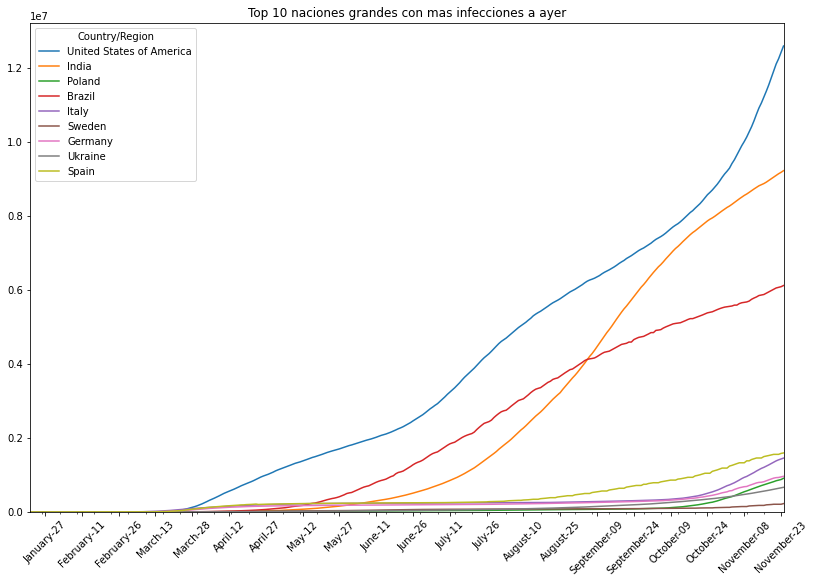

<module 'matplotlib.pyplot' from '/root/anaconda2/envs/jupyter/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [9]:
title="Top 10 naciones grandes con mas infecciones a ayer"
display(HTML(f"""<h1 id='{title}'>{title}</h1>"""))
df = get_data()

naciones_pintar = df_country.sort_values(by='infected last_day', ascending=False).head(10)['Country/Region'].values
df_country.sort_values(by='infected last_day', ascending=False).head(10)

pintar_grafico(df,naciones_pintar,title)



In [10]:
def pintar_grafico_daily(df, array_naciones_pintar ,title):
    df = df.T
    df = df.iloc[1:]
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header
    df = df.iloc[2:]
    df.index = pd.to_datetime(df.index)
    df = df[array_naciones_pintar]
    chart_df = df

    pd.plotting.register_matplotlib_converters()
    
    df_daily_increments = pd.DataFrame()
    for country in chart_df.columns:
        df_daily_increments[country] = chart_df[country].pct_change().rolling(window=7).mean()

    df_daily_increments    

    chart_df = df_daily_increments
    chart_df.tail(45).plot(legend=True,figsize=(13.5,9))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.xticks(rotation=45)

    ax = plt.gca()

    ax.set_title(title)
    ax.set_ylim(ymin=0)

    plt.show()

    chart_df.tail(30).style.format ({ c : "{:20,.2f}" for c in df.columns }).background_gradient(cmap='Wistia', )


    return chart_df


#pintar_grafico_daily(df,naciones_pintar,"Top 10 countries more cases, daily percentage change")
df_country

,Country/Region,infected last_day,PopTotal,Infected/Million
0,Afghanistan,292,38928341,7.500962
1,Albania,744,2877800,258.530822
2,Algeria,1133,43851043,25.837470
3,Andorra,47,77265,608.296124
4,Angola,108,32866267,3.286044
...,...,...,...,...
246,Vanuatu,0,307150,0.000000
247,Western Sahara,0,597330,0.000000
248,Yemen,7,29825967,0.234695
249,Zambia,12,18383956,0.652743


In [11]:
#pintar_grafico_daily(df,naciones_pintar,"Top 10 countries more cases, daily percentage change")